In [2]:

"""""
# Training parameters.
learning_rate = 0.001
training_steps = 5000
batch_size = 250
display_step = 500

# Network parameters.
n_hidden =  300# Number of neurons.



# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(87000).batch(batch_size).prefetch(1)


# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h1': tf.Variable(random_normal([num_features, n_hidden])),
    'h2': tf.Variable(random_normal([n_hidden, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_classes]))
}


def neural_nets(input_data):
    hidden_layer1 = tf.add(tf.matmul(input_data,weights['h1']),biases['b'])
    hidden_layer1 = tf.nn.sigmoid(hidden_layer1)
    
    hidden_layer2 = tf.add(tf.matmul(hidden_layer1,weights['h2']),biases['b'])
    hidden_layer2 = tf.nn.sigmoid(hidden_layer2)
    
    out_layer = tf.add(tf.matmul(hidden_layer1,weights['out']),biases['out'])
    
    return tf.nn.softmax(out_layer)



def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_nets(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))




def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    #print("argmax:",tf.argmax(y_pred,1))
    #print("cast",tf.cast(y_true, tf.int64))
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)



# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_nets(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))
"""

'""\n# Training parameters.\nlearning_rate = 0.001\ntraining_steps = 5000\nbatch_size = 250\ndisplay_step = 500\n\n# Network parameters.\nn_hidden =  300# Number of neurons.\n\n\n\n# Use tf.data API to shuffle and batch data.\ntrain_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))\ntrain_data = train_data.repeat().shuffle(87000).batch(batch_size).prefetch(1)\n\n\n# Store layers weight & bias\n\n# A random value generator to initialize weights initially\nrandom_normal = tf.initializers.RandomNormal()\n\nweights = {\n    \'h1\': tf.Variable(random_normal([num_features, n_hidden])),\n    \'h2\': tf.Variable(random_normal([n_hidden, n_hidden])),\n    \'out\': tf.Variable(random_normal([n_hidden, num_classes]))\n}\nbiases = {\n    \'b\': tf.Variable(tf.zeros([n_hidden])),\n    \'out\': tf.Variable(tf.zeros([num_classes]))\n}\n\n\ndef neural_nets(input_data):\n    hidden_layer1 = tf.add(tf.matmul(input_data,weights[\'h1\']),biases[\'b\'])\n    hidden_layer1 = tf.nn.sigmoid(hidde

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization

import os
import cv2
import glob
import pickle
import random
import warnings

In [4]:
batch_size = 32
img_height = 128
img_width = 128
epochs = 30
num_classes = 27
img_channels = 3

In [5]:
main_folder_path = r"D:\SixthSemProjects\ASL_Alphabet_Dataset\asl_alphabet_train"
subfolders = os.listdir(main_folder_path)

In [6]:
print(subfolders)

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


IndexError: index 30 is out of bounds for axis 0 with size 30

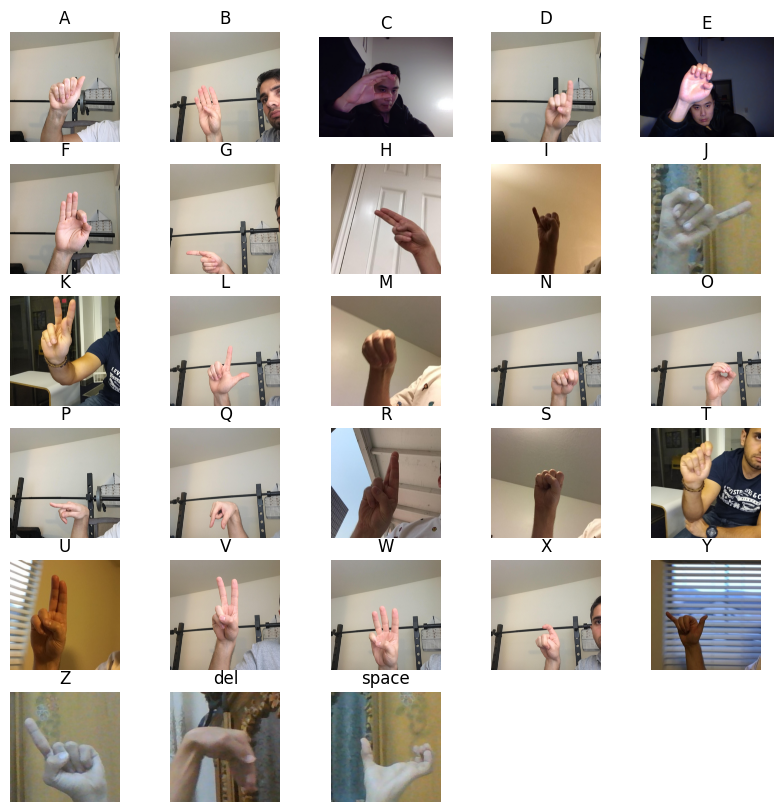

In [7]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')


df = pd.DataFrame({'Label': label, 'Count': count})

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

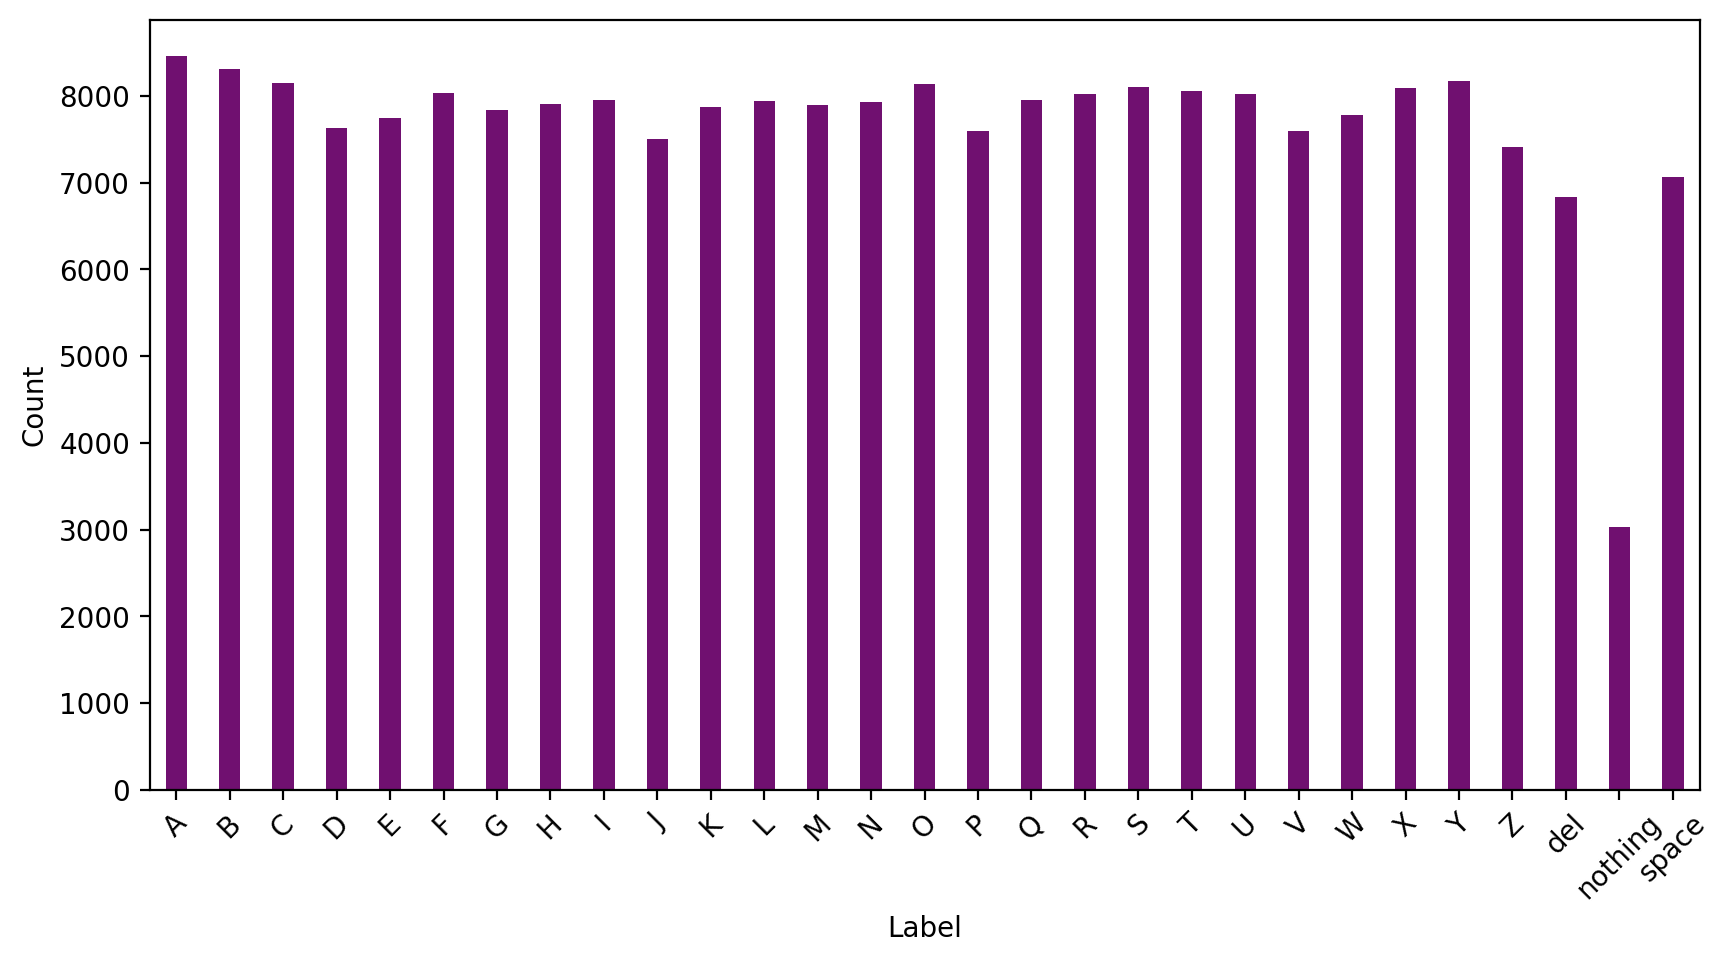

In [ ]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.title('Class distribution in Dataset',fontsize=15)

sns.barplot(data=df, x='Label', y='Count', width=0.4, color='purple')

plt.xticks(rotation = 45)
plt.show()

In [ ]:
folder_path = r"D:\SixthSemProjects\ASL_Alphabet_Dataset\asl_alphabet_train"
subfolder_content = os.listdir(folder_path) 
subfolder_content
subfolder_path = os.path.join(folder_path, subfolder_content[0])

letter_A_content = os.listdir(subfolder_path) 

A_count = len(letter_A_content)
A_count

8458

In [ ]:
dict_count = {} 

for letter in subfolder_content: 
    subfolder_path = os.path.join(folder_path, letter)  
    letter_files = os.listdir(subfolder_path) 

    count = len(letter_files)
    dict_count[letter] = count  
print(dict_count)


{'A': 8458, 'B': 8309, 'C': 8146, 'D': 7629, 'del': 6836, 'E': 7744, 'F': 8031, 'G': 7844, 'H': 7906, 'I': 7953, 'J': 7503, 'K': 7876, 'L': 7939, 'M': 7900, 'N': 7932, 'nothing': 3030, 'O': 8140, 'P': 7601, 'Q': 7954, 'R': 8021, 'S': 8109, 'space': 7071, 'T': 8054, 'U': 8023, 'V': 7597, 'W': 7787, 'X': 8093, 'Y': 8178, 'Z': 7410}


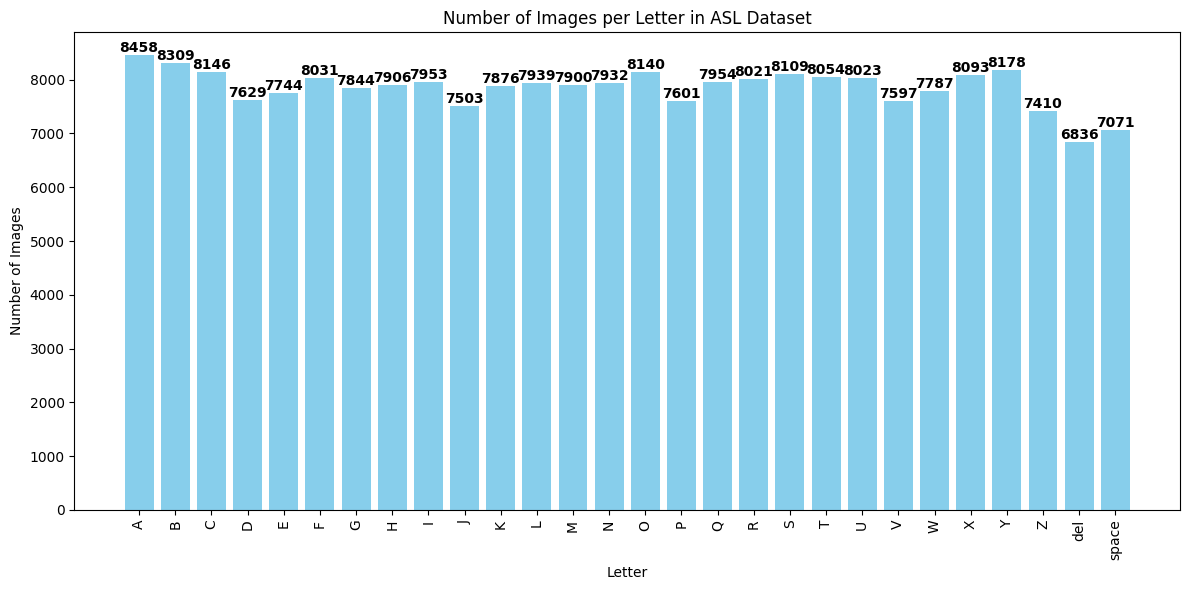

In [ ]:
main_folder_path = 'D:\\SixthSemProjects\\ASL_Alphabet_Dataset\\asl_alphabet_train'

subfolders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))]

image_counts = {}

for letter in subfolders:
    subfolder_path = os.path.join(main_folder_path, letter)
    letter_files = os.listdir(subfolder_path) 
    image_counts[letter] = len(letter_files)  


sorted_letters = sorted(image_counts.keys())
sorted_counts = [image_counts[letter] for letter in sorted_letters]

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_letters, sorted_counts, color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontweight='bold', fontsize=10)
    
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in ASL Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import shutil

source_base_folder = 'D:\\SixthSemProjects\\ASL_Alphabet_Dataset\\asl_alphabet_train'
destination_base_folder = 'D:\\SixthSemProjects\\ASL_Alphabet_Dataset\\randomly_selected_train_5k'

subfolders = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
for letter in subfolders:
    source_folder = os.path.join(source_base_folder, letter)
    destination_folder = os.path.join(destination_base_folder, letter)  
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    if len(image_files) >= 5000:
        random_selected_files = random.sample(image_files, 5000)
    else:
        random_selected_files = image_files
    for image in random_selected_files:
        source_path = os.path.join(source_folder, image)
        destination_path = os.path.join(destination_folder, image)
        shutil.copy(source_path, destination_path)
    print(f"5000 random images {letter}.")

print("done!")


5000 random images (or fewer, if not enough) have been selected and copied for A.
5000 random images (or fewer, if not enough) have been selected and copied for B.
5000 random images (or fewer, if not enough) have been selected and copied for C.
5000 random images (or fewer, if not enough) have been selected and copied for D.
5000 random images (or fewer, if not enough) have been selected and copied for del.
5000 random images (or fewer, if not enough) have been selected and copied for E.
5000 random images (or fewer, if not enough) have been selected and copied for F.
5000 random images (or fewer, if not enough) have been selected and copied for G.
5000 random images (or fewer, if not enough) have been selected and copied for H.
5000 random images (or fewer, if not enough) have been selected and copied for I.
5000 random images (or fewer, if not enough) have been selected and copied for J.
5000 random images (or fewer, if not enough) have been selected and copied for K.
5000 random im

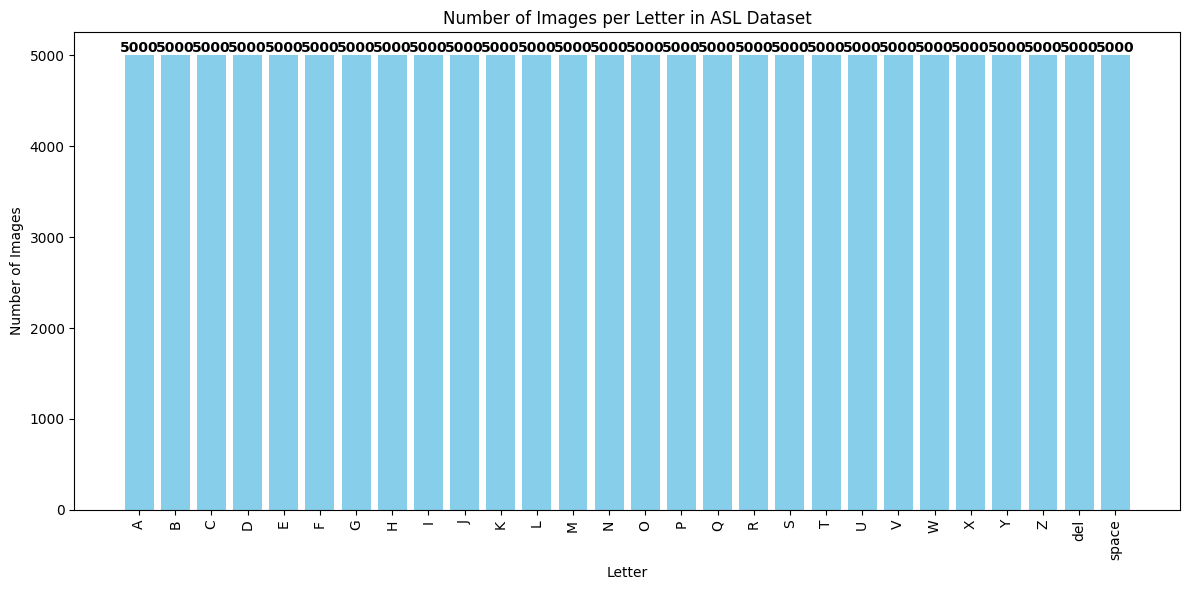

In [ ]:
main_folder_path = r'D:\SixthSemProjects\ASL_Alphabet_Dataset\randomly_selected_train_5k'

subfolders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))]

image_counts = {}

for letter in subfolders:
    subfolder_path = os.path.join(main_folder_path, letter)
    letter_files = os.listdir(subfolder_path) 
    image_counts[letter] = len(letter_files)  


sorted_letters = sorted(image_counts.keys())
sorted_counts = [image_counts[letter] for letter in sorted_letters]

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_letters, sorted_counts, color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontweight='bold', fontsize=10)
    
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in ASL Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [8]:
main_folder_path = r"D:\SixthSemProjects\ASL_Alphabet_Dataset\randomly_selected_train_5k"
subfolders = os.listdir(main_folder_path)

IndexError: index 30 is out of bounds for axis 0 with size 30

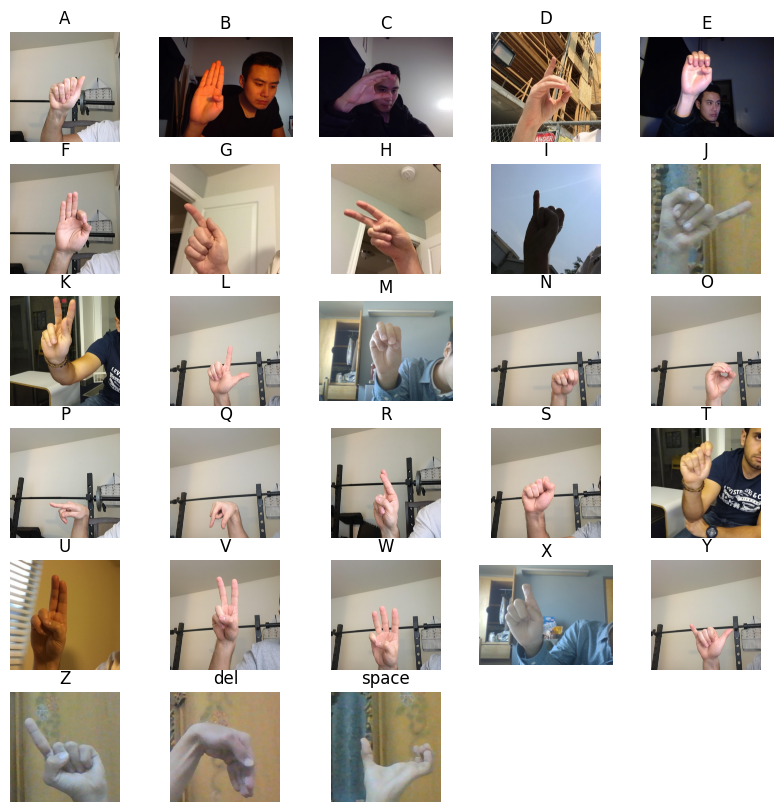

In [9]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')


df = pd.DataFrame({'Label': label, 'Count': count})

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

In [10]:
df['Count'].min(), df['Count'].max()

(5000, 5000)

In [11]:
categories

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'del',
 27: 'space'}

In [12]:
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.20,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.,)

# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=1,
    target_size=(img_height, img_width),
    shuffle=False
)


Found 95200 validated image filenames belonging to 28 classes.
Found 23800 validated image filenames belonging to 28 classes.
Found 21000 validated image filenames belonging to 28 classes.


In [15]:
image_shape = (128, 128, 3)
print(200*200*3)
print(128*128*3)

120000
49152


In [16]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [19]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (5, 5), input_shape=image_shape)) ##32 filters, 5x5 kernel, input shape is 128x128x3
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Flatten()) ##flatten the data
cnn_model.add(Dense(128, activation='relu')) ##128 neurons, activation function
cnn_model.add(Dense(28, activation='softmax')) ##output layer, 27 neurons, activation function

display(cnn_model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 activation_3 (Activation)   (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 60, 60, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  

None

In [20]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
cnn_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/30
2975/2975 [==============================] - 920s 309ms/step - loss: 0.7956 - accuracy: 0.7682 - val_loss: 0.2215 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 2/30
2975/2975 [==============================] - 776s 261ms/step - loss: 0.1379 - accuracy: 0.9583 - val_loss: 0.1640 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 3/30
2975/2975 [==============================] - 765s 257ms/step - loss: 0.0834 - accuracy: 0.9743 - val_loss: 0.1337 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 4/30
2975/2975 [==============================] - 769s 259ms/step - loss: 0.0669 - accuracy: 0.9800 - val_loss: 0.1212 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 5/30
2975/2975 [==============================] - 807s 271ms/step - loss: 0.0497 - accuracy: 0.9855 - val_loss: 0.1738 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 6/30
2975/2975 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9872
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2975/2975 [==========

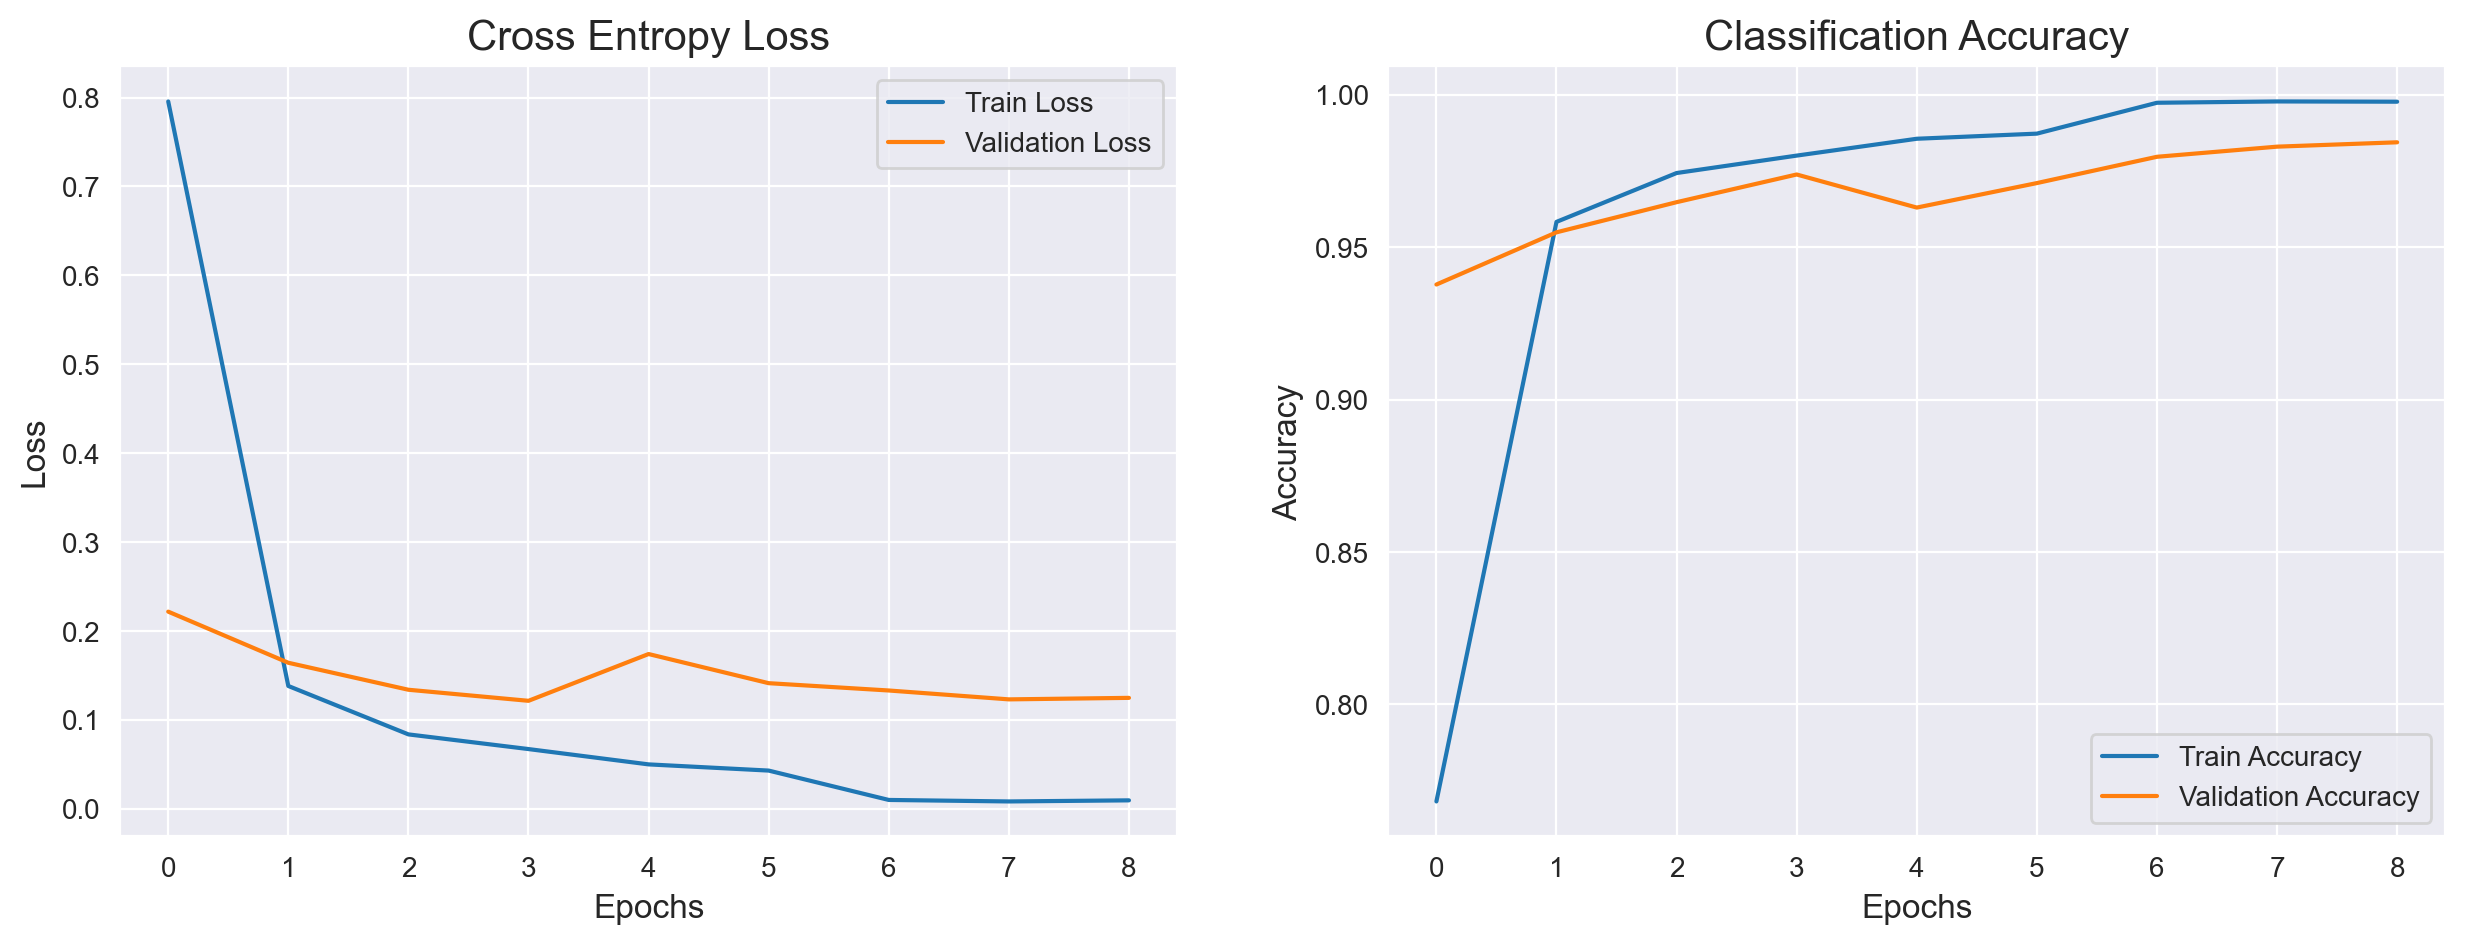

In [21]:
metrics = pd.DataFrame(cnn_model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [22]:
cnn_model.save('cnn_model2.h5')

In [24]:
predicted_class = cnn_model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 20455
Incorrect predicted classes: 545


In [25]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       0.94      0.97      0.95       750
           B       0.97      0.97      0.97       750
           C       0.98      0.98      0.98       750
           D       0.97      0.99      0.98       750
           E       0.99      0.95      0.97       750
           F       0.97      0.98      0.98       750
           G       0.97      0.95      0.96       750
           H       0.96      0.99      0.97       750
           I       0.98      0.95      0.96       750
           J       0.97      0.99      0.98       750
           K       0.97      0.99      0.98       750
           L       0.97      0.99      0.98       750
           M       0.99      0.96      0.98       750
           N       0.98      0.96      0.97       750
           O       0.97      0.98      0.97       750
           P       1.00      0.99      0.99       750
           Q       0.99      0.99      0.99       750
           R       0.96    

In [27]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=28)

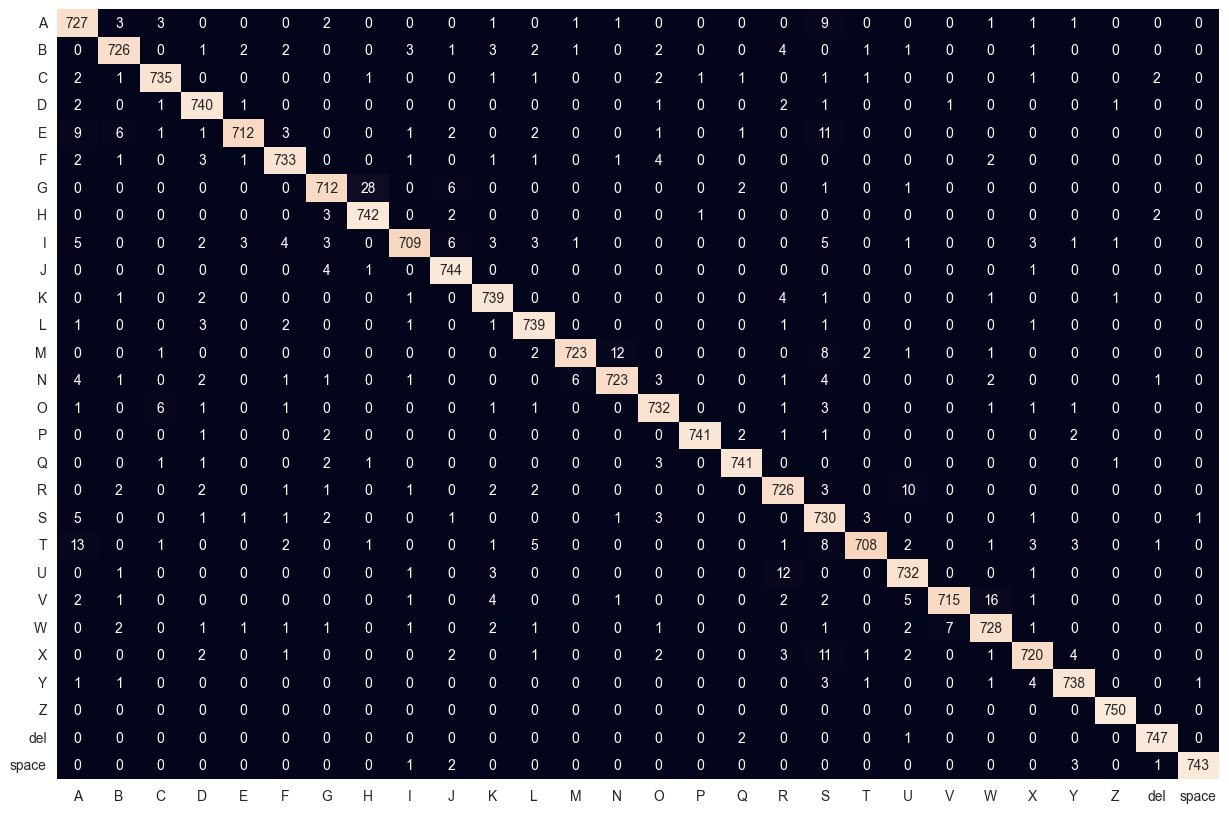

In [28]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()